<a href="https://colab.research.google.com/github/pranav168/Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [26]:
from google.colab import drive                                                  #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd                                                             #loading all the Required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10


In [29]:
df= pd.read_excel('/content/drive/MyDrive/Copy of Online Retail.xlsx')          #Loading the Dataset

In [30]:
df.info()                                                                       #Data contains a lot of Nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [33]:
df.isna().sum()                                                                 #135080 nulls in Customer id and 1454 nulls in Description

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [36]:
column_list=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                           #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['CustomerID','Description']:                                                                    #colur red shows the  Variable with missing values
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,InvoiceNo,InvoiceNo_count,StockCode,StockCode_count,Description,Description_count,Quantity,Quantity_count,InvoiceDate,InvoiceDate_count,UnitPrice,UnitPrice_count,CustomerID,CustomerID_count,Country,Country_count
0,573585,1114,85123A,2313,WHITE HANGING HEART T-LIGHT HOLDER,2369,1,148227,2011-10-31 14:41:00,1114,1.250000,50496,17841.000000,7983,United Kingdom,495478
1,581219,749,22423,2203,REGENCY CAKESTAND 3 TIER,2200,2,81829,2011-12-08 09:28:00,749,1.650000,38181,14911.000000,5903,Germany,9495
2,581492,731,85099B,2159,JUMBO BAG RED RETROSPOT,2159,12,61063,2011-12-09 10:03:00,731,0.850000,28497,14096.000000,5128,France,8557
3,580729,721,47566,1727,PARTY BUNTING,1727,6,40868,2011-12-05 17:24:00,721,2.950000,27768,12748.000000,4642,EIRE,8196
4,558475,705,20725,1639,LUNCH BAG RED RETROSPOT,1638,4,38484,2011-06-29 15:58:00,705,0.420000,24533,14606.000000,2782,Spain,2533
5,579777,687,84879,1502,ASSORTED COLOUR BIRD ORNAMENT,1501,3,37121,2011-11-30 15:13:00,687,4.950000,19040,15311.000000,2491,Netherlands,2371
6,581217,676,22720,1477,SET OF 3 CAKE TINS PANTRY DESIGN,1473,24,24021,2011-12-08 09:20:00,676,3.750000,18600,14646.000000,2085,Belgium,2069
7,537434,675,22197,1476,PACK OF 72 RETROSPOT CAKE CASES,1385,10,22288,2010-12-06 16:57:00,675,2.100000,17697,13089.000000,1857,Switzerland,2002
8,580730,662,21212,1385,LUNCH BAG BLACK SKULL.,1350,8,13129,2011-12-05 17:28:00,662,2.460000,17091,13263.000000,1677,Portugal,1519
9,538071,652,20727,1350,NATURAL SLATE HEART CHALKBOARD,1280,5,11757,2010-12-09 14:09:00,652,2.080000,17005,14298.000000,1640,Australia,1259


In [37]:
final_tally                                                                     # Gives (No. of unique elements in Variable, Total of all Variable, Total of Top 10 Variable )                                                          

[('InvoiceNo', (25900, 541909, 7372)),
 ('StockCode', (4070, 541909, 17231)),
 ('Description', (4223, 540455, 17082)),
 ('Quantity', (722, 541909, 478787)),
 ('InvoiceDate', (23260, 541909, 7372)),
 ('UnitPrice', (1630, 541909, 258908)),
 ('CustomerID', (4372, 406829, 36188)),
 ('Country', (38, 541909, 533479))]

here important thing to note is that :


1.   Only 25900 unique Invoice
2.   Only 4070 unique StokeCode(which means number of products =4070)
3.   There are only 4372 Unique Customers (thus we should look a way to group data as per customers, thus we will have to treat the customers with Nan values as similar.
4.  only 38 Country of which 10 country represents almost entire data, and UK alone explain 90% Data thus we will group country as 'UK' and 'Others'.
5.  Also well be droping Description Coulmns as we already have Stockcode for product mapping also their are few Nan in Description Coulmns



In [40]:
df['Order Status']=df['InvoiceNo'].apply(lambda x: np.where(str(x)[0]=='C',0,1))                 #As there are some Canceled Data in the Transaction well be marking them as '0'.
print(df['Order Status'].value_counts())                                                         #Counting the Number of Canceled Orders.
try:
  df.drop('Description',axis=1,inplace=True)
  df.dropna(inplace=True)
except:
  pass
df['Country']=df['Country'].apply(lambda x: mp.where)

1    397924
0      8905
Name: Order Status, dtype: int64


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order Status
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1


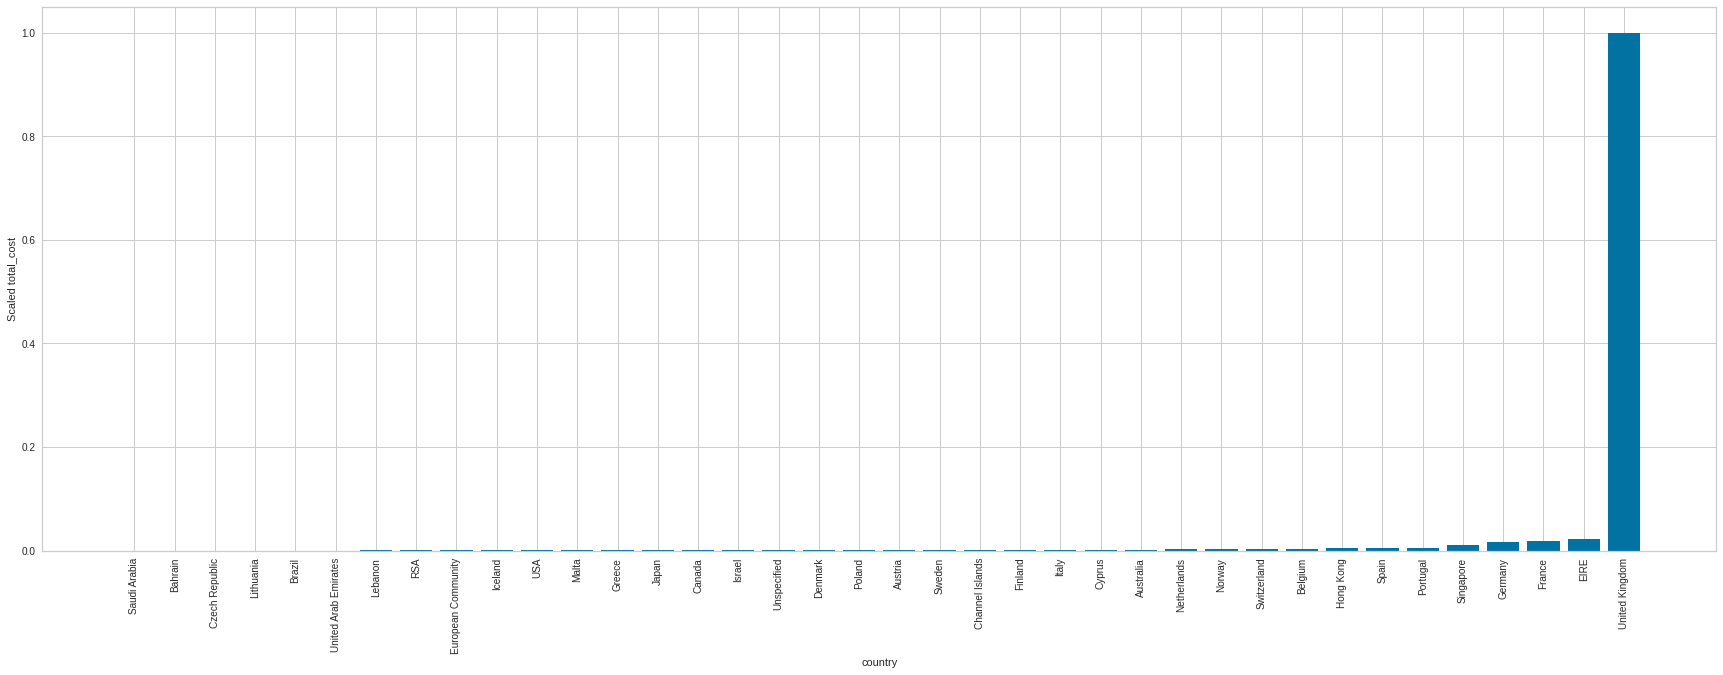

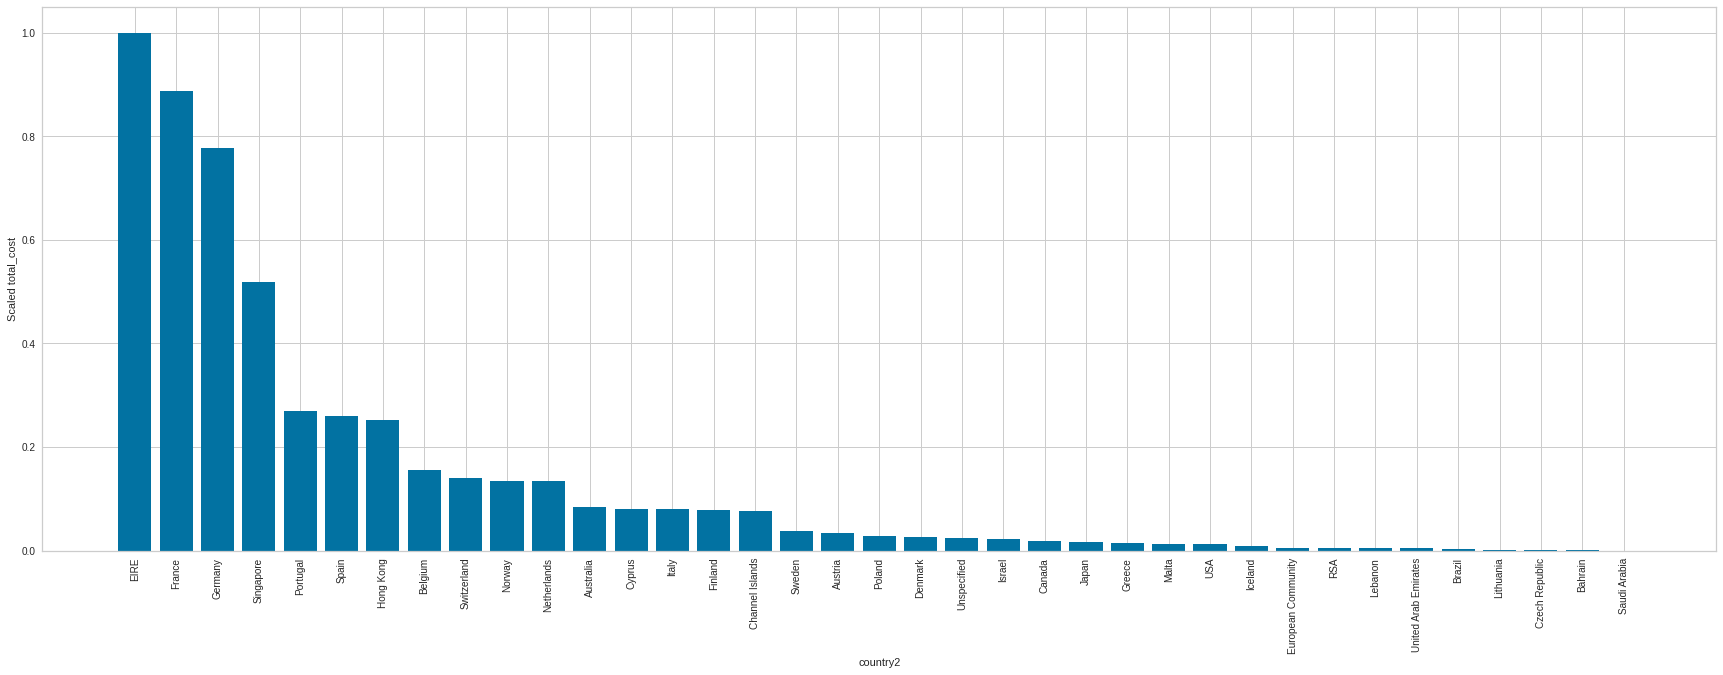

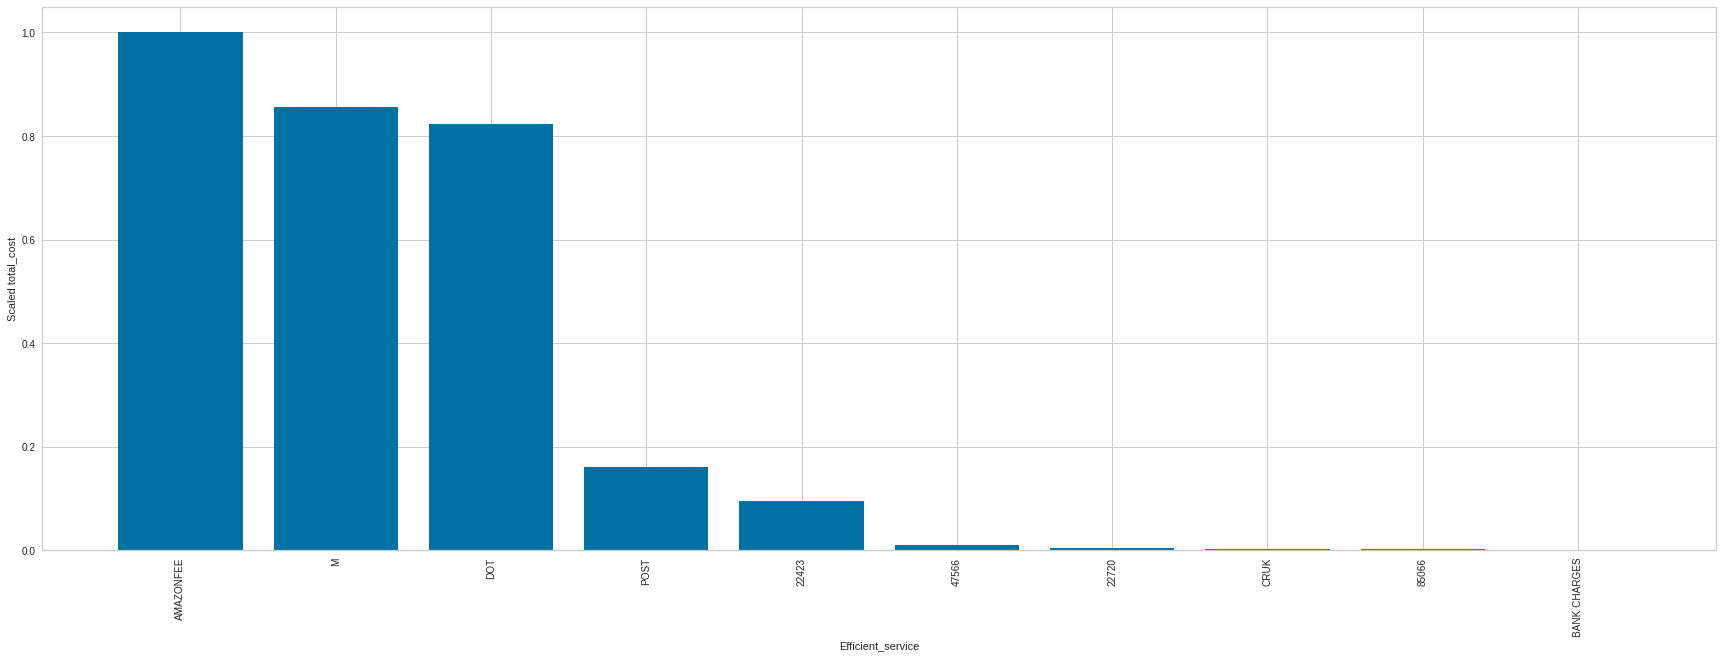

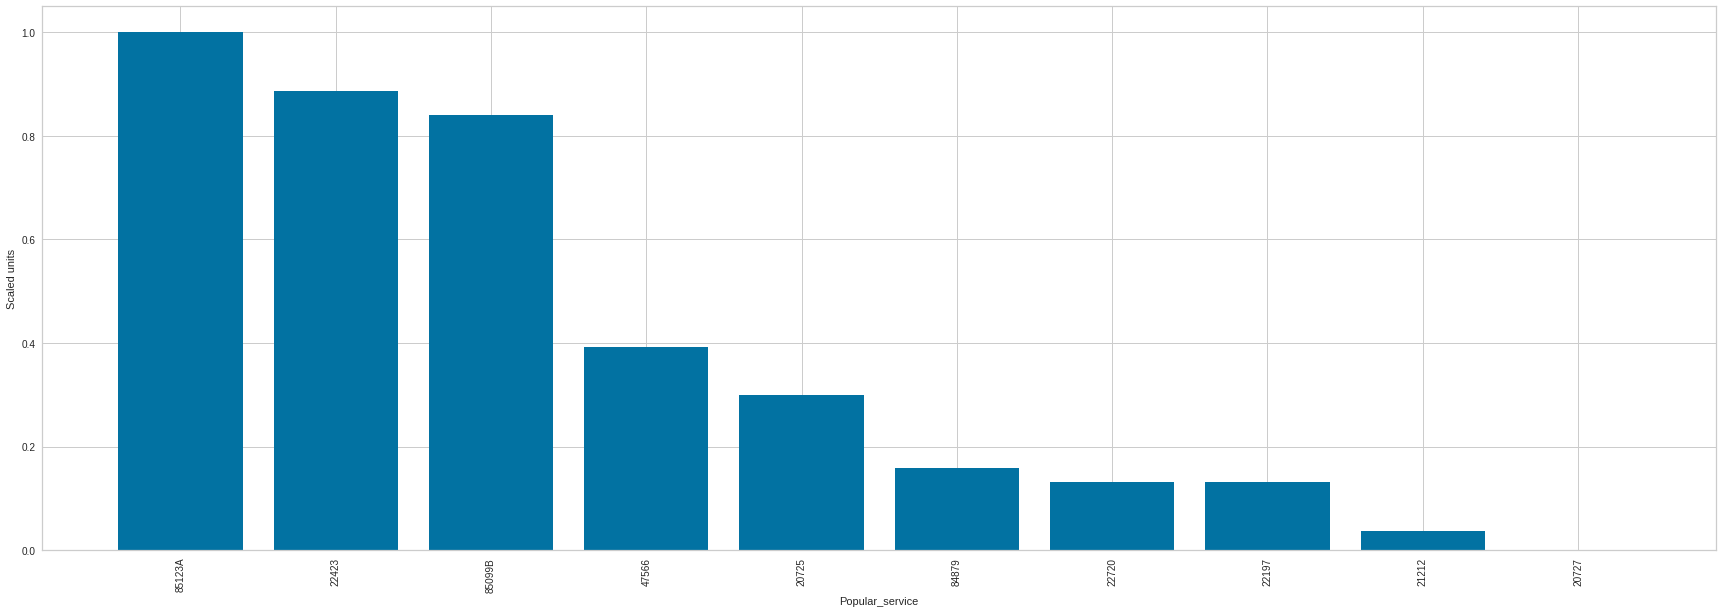

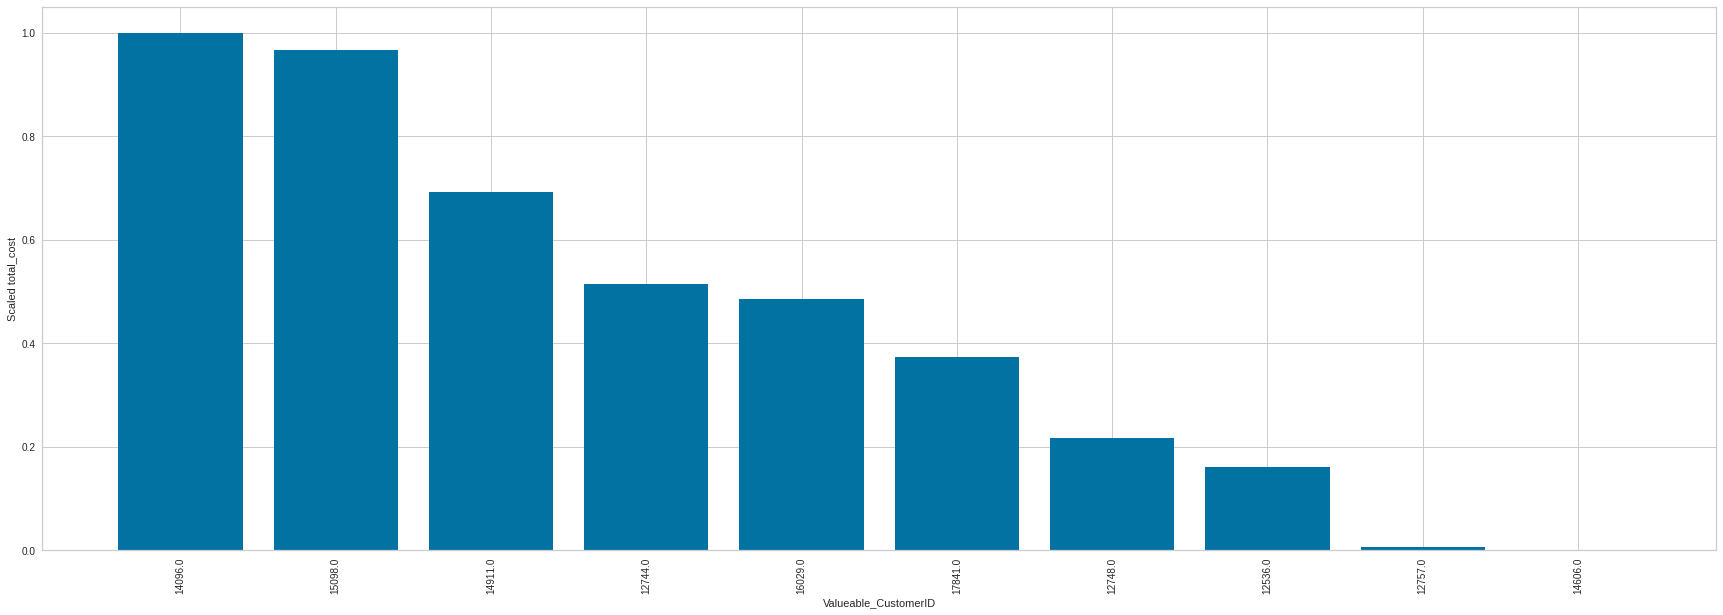

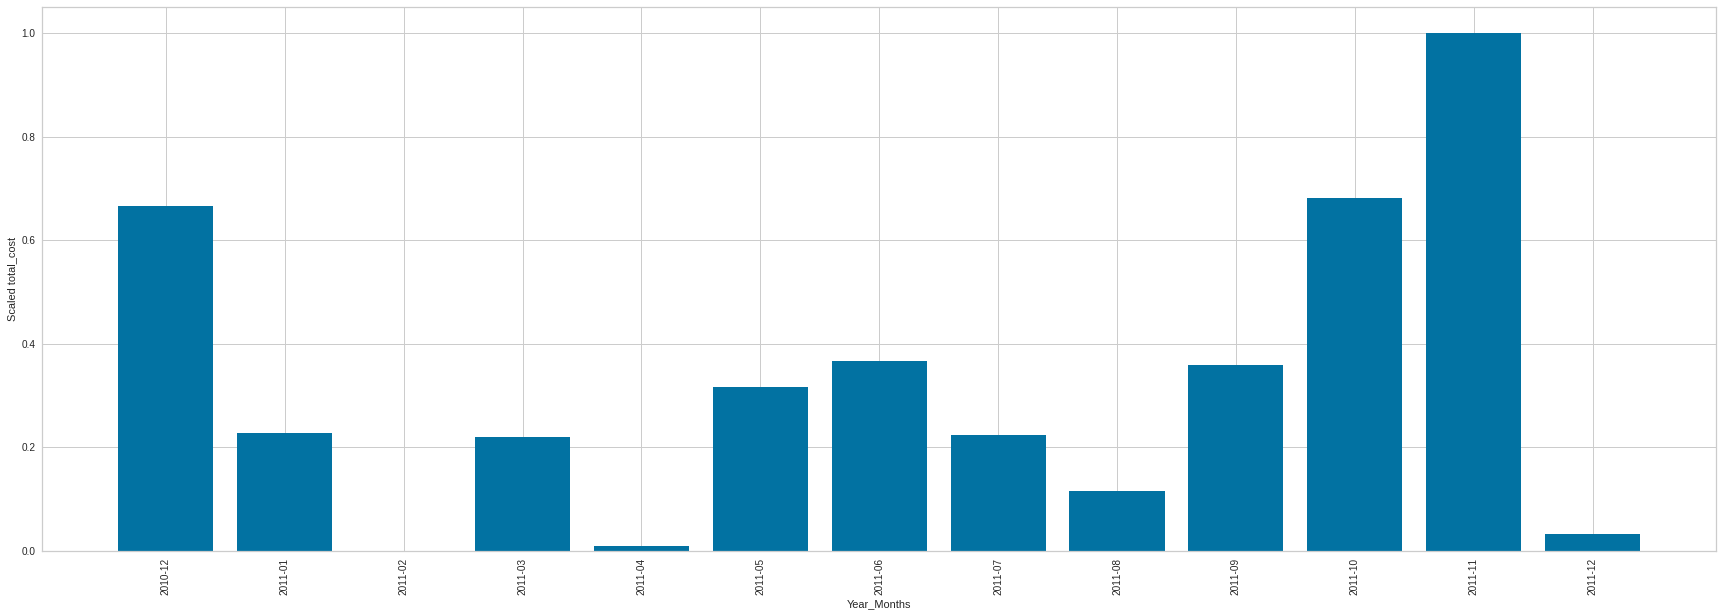

In [ ]:
scaler=MinMaxScaler()
total_cost_vs_country=df.groupby(by='Country')['UnitPrice'].sum().sort_values(ascending=True)
total_cost_vs_country2=total_cost_vs_country.drop('United Kingdom').sort_values(ascending=False) # Nothing conclusive as value for United Kindoms is really high thus removing it to explore the condition for rest of the countries.
total_cost_vs_Efficient_service_code=df.groupby('StockCode')['UnitPrice'].sum().sort_values(ascending=False).head(10)
units_vs_Popular_service_code=df.groupby('StockCode')['UnitPrice'].count().sort_values(ascending=False).head(10)
total_cost_vs_Valueable_CustomerID= df.groupby('CustomerID')['UnitPrice'].sum().sort_values(ascending=False).head(10)
total_cost_vs_Year_Months=df.groupby(by='Year_Month')['UnitPrice'].sum()
plots=[total_cost_vs_country,total_cost_vs_country2,total_cost_vs_Efficient_service_code,units_vs_Popular_service_code,total_cost_vs_Valueable_CustomerID,total_cost_vs_Year_Months]
plot2=['total_cost_vs_country','total_cost_vs_country2','total_cost_vs_Efficient_service','units_vs_Popular_service','total_cost_vs_Valueable_CustomerID','total_cost_vs_Year_Months']

count=0
for i in plots:
  plt.figure(figsize=(30,10))
  plt.bar(i.index.astype(str),scaler.fit_transform(i.values.reshape(-1,1)).reshape(1,-1)[0])
  plt.xlabel(plot2[count].split('_vs_')[1])
  plt.ylabel('Scaled '+plot2[count].split('_vs_')[0])
  plt.xticks(rotation=90)
  plt.show()
  count+=1

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order Status,Year_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,2010-12


In [ ]:
plots=[total_cost_vs_country,total_cost_vs_Year_Months]
variables=['Country','Year_Month']
count=0
for i in plots:
  try:
    temp=[]
    weight=[]
    for j in i.sort_values(ascending=False).index:
      temp.append(j)
    for j in range(0,len(i)):
      weight.append(j)
    temp_weight=dict(zip(temp,weight))
    df[variables[count]]=df[variables[count]].apply(lambda x: temp_weight[x])
  except:
    print('nahi challa')
  count+=1

In [ ]:
df3=df[['Quantity','UnitPrice','Country','Year_Month']]
df3

,Quantity,UnitPrice,Country,Year_Month
0,6,2.55,0,2
1,6,3.39,0,2
2,8,2.75,0,2
3,6,3.39,0,2
4,6,3.39,0,2
...,...,...,...,...
541904,12,0.85,2,10
541905,6,2.10,2,10
541906,4,4.15,2,10
541907,4,4.15,2,10


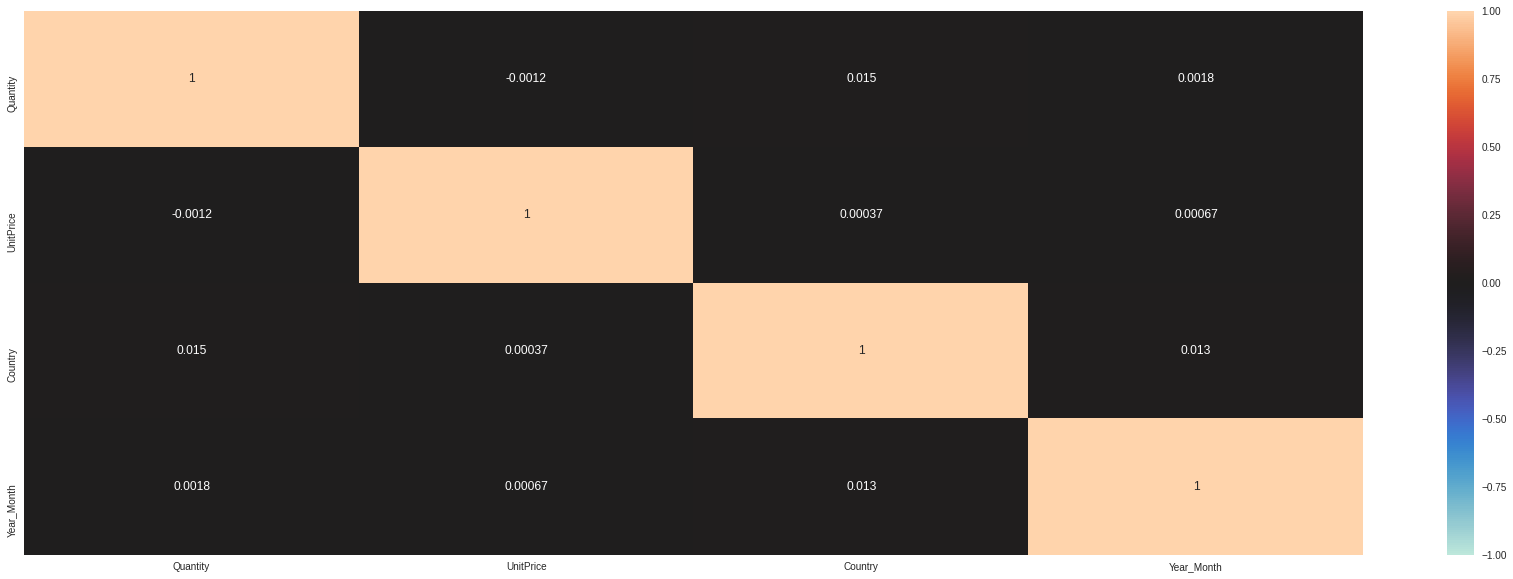

In [ ]:
a = df3.corr()
plt.figure(figsize=(30,10))
sns.heatmap(a,vmin=-1,vmax=1,center=0,annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

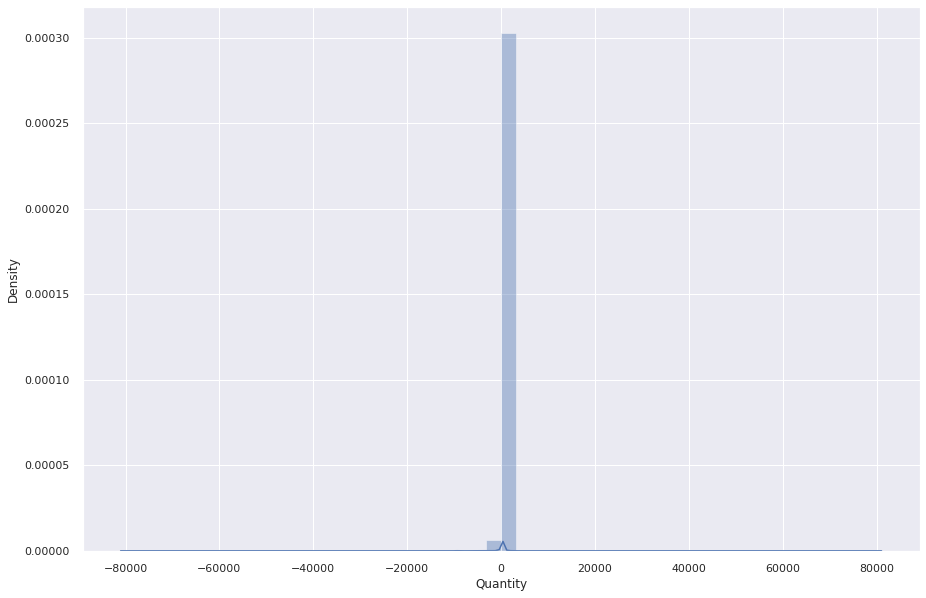

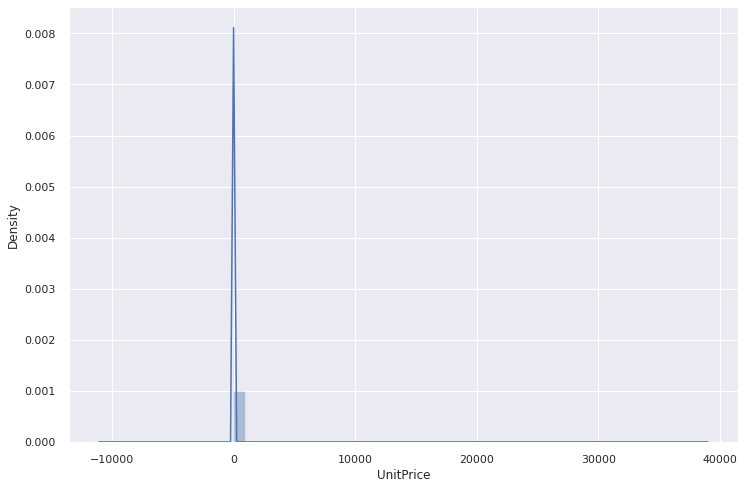

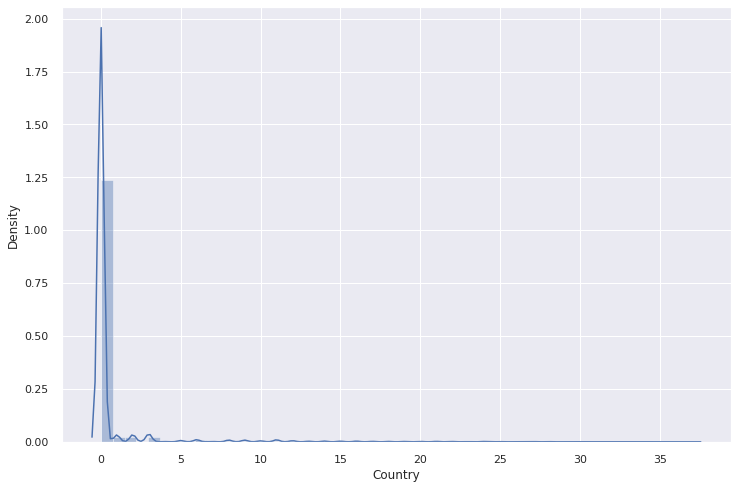

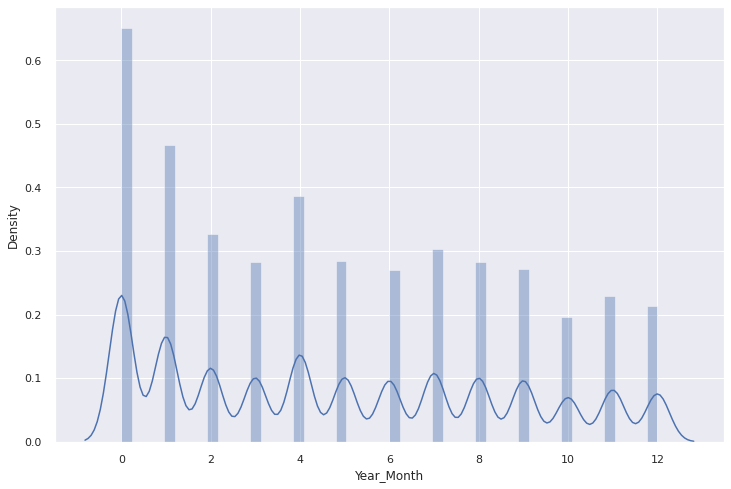

In [ ]:
count=0
for i in df3.columns:
  count+=1
  plt.figure(count)
  sns.set(rc={'figure.figsize':(12,8)})
  sns.distplot(df3[i])
  
